# Evaluation using the BeFree corpus 

### EUADR dataset
The EU-ADR dataset contains annotations on drugs, diseases, genes and proteins, and associations between them. In this study, we used only GDAs to evaluate the method. Each association is classified according to its level of certainty as positive association (PA), negative association (NA), speculative association (SA); or false association (FA). The EU-ADR corpus is based on 100 MEDLINE abstracts for each association set, and its annotation was conducted by three experts. 


#  -------------------------------------------------------------------------------------------

# imports

In [1]:
import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import numpy as np
from keras_tqdm import TQDMNotebookCallback
import nltk
import xml.etree.ElementTree as ET
import pandas as pd
import os
import string
from nltk.tokenize import TreebankWordTokenizer
from numpy.random import random_sample
import re
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.layers import Embedding, Flatten,LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation,  Input, merge,Conv1D,MaxPooling1D,GlobalMaxPooling1D,Convolution1D
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from keras.layers import Concatenate, concatenate
from keras import backend as K
from keras.layers import multiply
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

Using TensorFlow backend.


###  Define Callback functions to generate Mesures

In [2]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Experiments to reproduce the results of Table 8 

### Load Prerocssed Data

In [3]:
with open('../data/pickles/befree_EUADR_2class_PubMed-and-PMC-w2v.pickle', 'rb') as handle:        
    
    W_train = pickle.load(handle)
    print("W_train",len(W_train))
    d1_train = pickle.load(handle)
    print("d1_train",len(d1_train))
    d2_train = pickle.load(handle)
    print("d2_train",len(d2_train))
    Y_train = pickle.load(handle)
    print("Y_train",len(d2_train))
    Tr_word_list = pickle.load(handle)
    print("Tr_word_list",len(d2_train))
    word_vectors = pickle.load(handle)
    print("word_vectors",len(word_vectors))
    word_dict = pickle.load(handle)
    print("word_dict",len(word_dict))
    d1_dict = pickle.load(handle)
    print("d1_dict",len(d1_dict))
    d2_dict = pickle.load(handle)
    print("d2_dict",len(d2_dict))
    label_dict = pickle.load(handle)
    print("label_dict",len(label_dict))
    MAX_SEQUENCE_LENGTH = pickle.load(handle)
    print("MAX_SEQUENCE_LENGTH",MAX_SEQUENCE_LENGTH)


W_train 355
d1_train 355
d2_train 355
Y_train 355
Tr_word_list 355
word_vectors 1355
word_dict 1355
d1_dict 169
d2_dict 171
label_dict 4
MAX_SEQUENCE_LENGTH 102


### Create Position Embedding Vectors

In [4]:
import keras
from keras_pos_embd import TrigPosEmbedding

model = keras.models.Sequential()
model.add(TrigPosEmbedding(
    input_shape=(None,),
    output_dim=20,                      # The dimension of embeddings.
    mode=TrigPosEmbedding.MODE_EXPAND,  # Use `expand` mode
    name='Pos-Embd',
))
model.compile('adam', keras.losses.mae, {})
model.summary()

d1_train_embedded=model.predict(d1_train)

d1_train_embedded.shape

d2_train_embedded=model.predict(d2_train)

d2_train_embedded.shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Pos-Embd (TrigPosEmbedding)  (None, None, 20)          0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


(355, 102, 20)

### Prepare Word Embedding Layer

In [9]:
EMBEDDING_DIM=word_vectors.shape[1]
embedding_matrix=word_vectors
print(EMBEDDING_DIM)
print(len(embedding_matrix))

param='binary'

def create_embedding_layer(l2_reg=0.01,use_pretrained=True,is_trainable=False):
    
    if use_pretrained:        
        return Embedding(len(word_dict) ,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=is_trainable,embeddings_regularizer=regularizers.l2(l2_reg))
    
    else:    
        return Embedding(len(word_dict) ,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH)
            
    

200
1355


### Prepare Attention Mechanism

In [10]:
INPUT_DIM = 2
TIME_STEPS = MAX_SEQUENCE_LENGTH


In [11]:
def attentionNew(inputs):
    inputs = Lambda(lambda x: tf.keras.backend.sigmoid(x))(inputs)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a_probs])
    output_attention_mul = Lambda(lambda x: tf.keras.backend.sigmoid(x))(output_attention_mul)
    return output_attention_mul


### Create the Model

In [71]:
dropRate=0.1
param='binary'
def build_model_positionAttention():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = create_embedding_layer(use_pretrained=True, is_trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    pos_embedd_1 = Input(shape=(MAX_SEQUENCE_LENGTH, 20), dtype='float32')
    pos_embedd_2 = Input(shape=(MAX_SEQUENCE_LENGTH, 20), dtype='float32')

    combined_input = concatenate([embedded_sequences, pos_embedd_1, pos_embedd_2])
    x = Conv1D(256, 7, activation='relu')(combined_input)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.5)(x)

    conv_sequence_7 = GlobalMaxPooling1D()(x)

    forward = LSTM(100, recurrent_dropout=0.05)(combined_input)
    backward = LSTM(100, go_backwards=True, recurrent_dropout=0.05)(combined_input)
    lstm_sequence = concatenate([forward, backward])

    merge = concatenate([conv_sequence_7, lstm_sequence])

    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05))(merge)
    x = Dropout(0.5)(x)
    preds = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=[sequence_input, pos_embedd_1, pos_embedd_2], outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1])
    
    return model
    

In [72]:
model = build_model_positionAttention()
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 102)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 102, 200)     271000      input_54[0][0]                   
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 102, 20)      0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 102, 20)      0                                            
___________________________________________________________________________________________

### Run the Evaluation using 10 fold Cross Validation  

In [73]:


validation_split_rate=0.1
skf = StratifiedKFold(n_splits=3, random_state=None)
Y = [np.argmax(y, axis=None, out=None) for y in Y_train]
#print(len(Y))
all_histories=[]
for trI, teI in skf.split(W_train,Y): 
    train_index =trI
    test_index  =teI
trainRate = (len(train_index)/len(Y))*100   
testRate = (len(test_index)/len(Y))*100
print ("TrainRate:{:.2f}% testRate:{:.2f}% validation:{:.2f}%  ".format(trainRate,testRate, trainRate*validation_split_rate))
#print(train_index, test_index)
X_train, X_test = W_train[train_index], W_train[test_index] 
pos_train1, pos_test1 = d1_train_embedded[train_index], d1_train_embedded[test_index] 
pos_train2, pos_test2 = d2_train_embedded[train_index], d2_train_embedded[test_index] 
y_train, y_test = Y_train[train_index], Y_train[test_index]

epochs =100
batch_size =32

history=model.fit([X_train,pos_train1,pos_train2], y_train,validation_split=validation_split_rate ,epochs=epochs, batch_size=batch_size,verbose=1)



TrainRate:66.76% testRate:33.24% validation:6.68%  
Train on 213 samples, validate on 24 samples
Epoch 1/100
213/213 [==============================] - 2s 10ms/step - loss: 588.4190 - acc: 0.6244 - f1: 0.6288 - val_loss: 586.2028 - val_acc: 1.0000 - val_f1: 1.0000
Epoch 2/100
213/213 [==============================] - 1s 6ms/step - loss: 586.1941 - acc: 0.6244 - f1: 0.6241 - val_loss: 584.2078 - val_acc: 1.0000 - val_f1: 1.0000
Epoch 3/100
213/213 [==============================] - 1s 6ms/step - loss: 584.4194 - acc: 0.6150 - f1: 0.6176 - val_loss: 582.8166 - val_acc: 1.0000 - val_f1: 1.0000
Epoch 4/100
213/213 [==============================] - 1s 6ms/step - loss: 582.8358 - acc: 0.5869 - f1: 0.5884 - val_loss: 581.4281 - val_acc: 1.0000 - val_f1: 1.0000
Epoch 5/100
213/213 [==============================] - 1s 6ms/step - loss: 581.5462 - acc: 0.7136 - f1: 0.7113 - val_loss: 580.3510 - val_acc: 1.0000 - val_f1: 1.0000
Epoch 6/100
213/213 [==============================] - 1s 6ms/step 

213/213 [==============================] - 1s 6ms/step - loss: 574.1089 - acc: 0.9202 - f1: 0.9218 - val_loss: 574.0098 - val_acc: 0.9583 - val_f1: 0.9583
Epoch 50/100
213/213 [==============================] - 1s 6ms/step - loss: 574.0829 - acc: 0.9249 - f1: 0.9262 - val_loss: 574.2167 - val_acc: 0.7917 - val_f1: 0.7917
Epoch 51/100
213/213 [==============================] - 1s 6ms/step - loss: 574.0534 - acc: 0.9343 - f1: 0.9352 - val_loss: 574.2448 - val_acc: 0.8333 - val_f1: 0.8333
Epoch 52/100
213/213 [==============================] - 1s 6ms/step - loss: 574.0410 - acc: 0.9484 - f1: 0.9486 - val_loss: 574.1356 - val_acc: 0.8333 - val_f1: 0.8333
Epoch 53/100
213/213 [==============================] - 1s 6ms/step - loss: 573.9812 - acc: 0.9531 - f1: 0.9507 - val_loss: 574.1518 - val_acc: 0.8333 - val_f1: 0.8333
Epoch 54/100
213/213 [==============================] - 1s 6ms/step - loss: 574.0305 - acc: 0.9155 - f1: 0.9150 - val_loss: 574.2424 - val_acc: 0.7917 - val_f1: 0.7917
Epoch

Epoch 98/100
213/213 [==============================] - 1s 6ms/step - loss: 573.6683 - acc: 0.9531 - f1: 0.9530 - val_loss: 573.5939 - val_acc: 0.9583 - val_f1: 0.9583
Epoch 99/100
213/213 [==============================] - 1s 6ms/step - loss: 573.7120 - acc: 0.9531 - f1: 0.9554 - val_loss: 574.1682 - val_acc: 0.8333 - val_f1: 0.8333
Epoch 100/100
213/213 [==============================] - 1s 6ms/step - loss: 573.6665 - acc: 0.9624 - f1: 0.9619 - val_loss: 573.7720 - val_acc: 0.9167 - val_f1: 0.9167


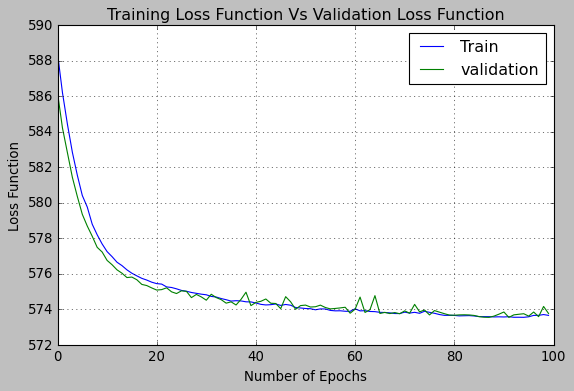

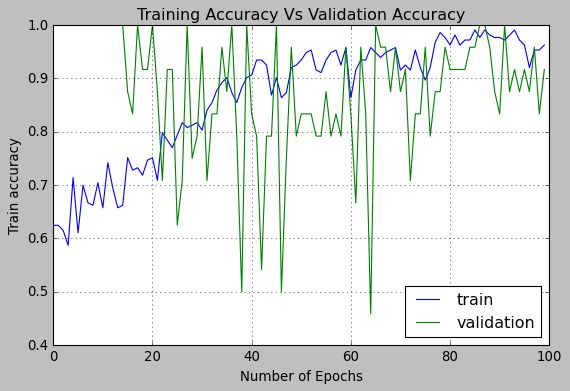

In [74]:
#Training & Validation accuracy
# visualizing  accuracy
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc = range(epochs)
plt.figure(1, figsize=(8, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Function')
plt.title('Training Loss Function Vs Validation Loss Function')
plt.grid(True)
plt.legend(['Train', 'validation'])
# print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.figure(2, figsize=(8, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Train accuracy')
plt.title('Training Accuracy Vs Validation Accuracy')
plt.grid(True)
plt.legend(['train', 'validation'], loc=4)
# print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

In [75]:
predicted = np.argmax(model.predict([X_test,pos_test1,pos_test2]), axis=1)
y_test_to_label= np.argmax(y_test, axis=1)
prec, reca, fscore, sup = precision_recall_fscore_support(y_test_to_label, predicted, average=param)
print(classification_report(y_test_to_label,predicted))

print(" Precision:{:.2f}% Recall:{:.2f}% Fscore:{:.2f}% ".format(prec*100, reca*100, fscore*100))

              precision    recall  f1-score   support

           0       0.25      0.13      0.17        31
           1       0.74      0.86      0.79        87

    accuracy                           0.67       118
   macro avg       0.49      0.50      0.48       118
weighted avg       0.61      0.67      0.63       118

 Precision:73.53% Recall:86.21% Fscore:79.37% 
